# LOAN DEFAULT PREDICTION

## 1) DATA CLEANING & PRE-PROCESSING

### 1.1) INSTALL AND IMPORT REQUIRED PACKAGES

In [1]:
!pip install numpy pandas seaborn matplotlib plotly scikit-learn imbalanced-learn xgboost category_encoders tensorflow transformers torch openai accelerate tf-keras sentencepiece

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pickle
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import tensorflow.keras.backend as K
import torch
import openai
import joblib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.utils import class_weight
from transformers import pipeline
from openai import OpenAI
from sklearn.utils.class_weight import compute_class_weight
from huggingface_hub import login
from sklearn.metrics import roc_curve, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

### 1.2) LOAD THE DATASET

In [4]:
data = pd.read_csv("loan-data.csv")

In [5]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0
2,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,Furniture,6.0,middle,POS industry with interest,365243.0,-797.0,-647.0,-647.0,-639.0,0.0
3,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-2310.0,-1980.0,-1980.0,-1976.0,1.0
4,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,Connectivity,4.0,middle,POS mobile without interest,365243.0,-784.0,-694.0,-724.0,-714.0,0.0


In [6]:
data.shape

(1048575, 158)

In [7]:
data.columns.to_list()

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE_x',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT_x',
 'AMT_ANNUITY_x',
 'AMT_GOODS_PRICE_x',
 'NAME_TYPE_SUITE_x',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START_x',
 'HOUR_APPR_PROCESS_START_x',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGIN

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Columns: 158 entries, SK_ID_CURR to NFLAG_INSURED_ON_APPROVAL
dtypes: float64(77), int64(49), object(32)
memory usage: 1.2+ GB


In [9]:
data.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048499e+06,1.047745e+06,1.048575e+06,1.048575e+06,1.048575e+06,...,3510.000000,1.048575e+06,1.048575e+06,821024.000000,632837.000000,632837.000000,632837.000000,632837.000000,632837.000000,632837.000000
mean,2.325970e+05,8.679589e-02,4.062180e-01,1.730444e+05,5.875356e+05,2.701891e+04,5.275946e+05,2.073174e-02,-1.631692e+04,6.876652e+04,...,0.771279,-8.808101e+02,3.083707e+02,16.053825,342322.950011,13468.407740,33228.619080,76606.909331,82324.210056,0.330169
std,7.649298e+04,2.815359e-01,7.191469e-01,2.209972e+05,3.848226e+05,1.394281e+04,3.530696e+05,1.334599e-02,4.352848e+03,1.453283e+05,...,0.101418,7.835497e+02,5.758829e+03,14.559881,88714.710257,71603.626391,106097.740101,149664.039306,153518.903600,0.470274
min,1.000020e+05,0.000000e+00,0.000000e+00,2.565000e+04,4.500000e+04,1.980000e+03,4.500000e+04,5.330000e-04,-2.520100e+04,-1.754600e+04,...,0.373150,-2.922000e+03,-1.000000e+00,0.000000,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.663520e+05,0.000000e+00,0.000000e+00,1.125000e+05,2.700000e+05,1.682550e+04,2.385000e+05,1.003200e-02,-1.998400e+04,-2.832000e+03,...,0.715645,-1.314000e+03,-1.000000e+00,6.000000,365243.000000,-1631.000000,-1246.000000,-1317.000000,-1270.000000,0.000000
50%,2.327300e+05,0.000000e+00,0.000000e+00,1.575000e+05,5.084955e+05,2.493900e+04,4.500000e+05,1.885000e-02,-1.603500e+04,-1.283000e+03,...,0.835095,-5.830000e+02,4.000000e+00,12.000000,365243.000000,-826.000000,-358.000000,-536.000000,-495.000000,0.000000
75%,2.990090e+05,0.000000e+00,1.000000e+00,2.070000e+05,8.086500e+05,3.457350e+04,6.795000e+05,2.866300e-02,-1.272750e+04,-2.830000e+02,...,0.852537,-2.710000e+02,8.500000e+01,24.000000,365243.000000,-409.000000,134.000000,-74.000000,-43.000000,1.000000
max,3.646250e+05,1.000000e+00,1.900000e+01,1.170000e+08,4.050000e+06,2.250000e+05,4.050000e+06,7.250800e-02,-7.673000e+03,3.652430e+05,...,1.000000,-2.000000e+00,4.000000e+06,84.000000,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


### 1.3) HANDLING MISSING VALUES

#### 1.3.1) CHECK MISSING VALUES PERCENTAGE

In [10]:
missing_percentage = (data.isnull().sum() / len(data)) * 100

In [11]:
missing_percentage

SK_ID_CURR                    0.000000
TARGET                        0.000000
NAME_CONTRACT_TYPE_x          0.000000
CODE_GENDER                   0.000000
FLAG_OWN_CAR                  0.000000
                               ...    
DAYS_FIRST_DUE               39.647903
DAYS_LAST_DUE_1ST_VERSION    39.647903
DAYS_LAST_DUE                39.647903
DAYS_TERMINATION             39.647903
NFLAG_INSURED_ON_APPROVAL    39.647903
Length: 158, dtype: float64

#### 1.3.2) IDENTIFY COLUMNS WITH MORE THAN 60% MISSING VALUES

In [12]:
threshold = 60
cols_to_drop = missing_percentage[missing_percentage > threshold].index.tolist()

In [13]:
cols_to_drop

['OWN_CAR_AGE',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'FLOORSMIN_AVG',
 'LIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'FLOORSMIN_MODE',
 'LIVINGAPARTMENTS_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'FLOORSMIN_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'FONDKAPREMONT_MODE',
 'RATE_INTEREST_PRIMARY',
 'RATE_INTEREST_PRIVILEGED']

#### 1.3.3) DROP THESE COLUMNS

In [14]:
data_cleaned = data.drop(columns=cols_to_drop)

In [15]:
data_cleaned.shape

(1048575, 139)

### 1.3.4) IDENTIFY NUMERICAL AND CATEGORICAL COLUMNS

In [16]:
numerical_cols = data_cleaned.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [17]:
numerical_cols

['SK_ID_CURR',
 'TARGET',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT_x',
 'AMT_ANNUITY_x',
 'AMT_GOODS_PRICE_x',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START_x',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'LANDAREA_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'LANDAREA_MODE',


In [18]:
categorical_cols = data_cleaned.select_dtypes(include=["object"]).columns.tolist()

In [19]:
categorical_cols

['NAME_CONTRACT_TYPE_x',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE_x',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START_x',
 'ORGANIZATION_TYPE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'NAME_CONTRACT_TYPE_y',
 'WEEKDAY_APPR_PROCESS_START_y',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE_y',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

#### 1.3.5) FILL NUMERICAL MISSING VALUES WITH MEDIAN

In [20]:
data_cleaned[numerical_cols] = data_cleaned[numerical_cols].fillna(data_cleaned[numerical_cols].median())

In [21]:
data_cleaned[numerical_cols].isnull().sum().sum()

np.int64(0)

#### 1.3.6) FILL CATEGORICAL MISSING VALUES WITH MODE

In [22]:
for col in categorical_cols:
    data_cleaned[col] = data_cleaned[col].fillna(data_cleaned[col].mode()[0])

In [23]:
data_cleaned[col].isnull().sum().sum()

np.int64(0)

#### 1.3.7) CHECK IF ALL MISSING VALUES ARE HANDLED

In [24]:
missing_values_after = data_cleaned.isnull().sum().sum()

In [25]:
missing_values_after

np.int64(0)

In [26]:
data_cleaned.shape, len(cols_to_drop), missing_values_after

((1048575, 139), 19, np.int64(0))

### 2) CATEGORICAL ENCODING

#### 2.1) IDENTIFY CATEGORICAL COLUMNS

In [27]:
categorical_cols = data_cleaned.select_dtypes(include=["object"]).columns.tolist()

In [28]:
categorical_cols

['NAME_CONTRACT_TYPE_x',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE_x',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START_x',
 'ORGANIZATION_TYPE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'NAME_CONTRACT_TYPE_y',
 'WEEKDAY_APPR_PROCESS_START_y',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE_y',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

#### 2.2) APPLY LABEL ENCODING TO CATEGORICAL COLUMNS

In [29]:
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data_cleaned[col] = le.fit_transform(data_cleaned[col])
    label_encoders[col] = le

#### 2.3) VERIFY ENCODING BY CHECKING DATA TYPES

In [30]:
data_cleaned.dtypes.value_counts(), data_cleaned.shape

(int64      80
 float64    59
 Name: count, dtype: int64,
 (1048575, 139))

### 3) FEATURE SCALING

#### 3.1) IDENTIFY NUMERICAL COLUMNS

In [31]:
numerical_cols = data_cleaned.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [32]:
numerical_cols

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE_x',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT_x',
 'AMT_ANNUITY_x',
 'AMT_GOODS_PRICE_x',
 'NAME_TYPE_SUITE_x',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START_x',
 'HOUR_APPR_PROCESS_START_x',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG

#### 3.2) APPLY STANDARDIZATION (Z-SCORE SCALING)

In [33]:
scaler = StandardScaler()

In [34]:
scaler

StandardScaler()

In [35]:
data_cleaned[numerical_cols] = scaler.fit_transform(data_cleaned[numerical_cols])

In [36]:
data_cleaned[numerical_cols].head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,-1.733427,3.243653,-0.284373,1.444543,-0.711207,0.617792,-0.564861,0.133285,-0.470186,-0.166275,...,-1.936093,0.679361,0.736497,1.837873,0.198105,-0.149221,-0.235436,-0.376691,-0.393034,-0.498849
1,-1.733414,-0.308294,-0.284373,-0.691929,-0.711207,-1.618667,-0.564861,0.438719,1.834526,0.622547,...,0.957574,-0.244322,0.736497,-0.000652,0.198105,-0.151915,-0.241516,-0.380871,-0.397083,2.004613
2,-1.733414,-0.308294,-0.284373,-0.691929,-0.711207,-1.618667,-0.564861,0.438719,1.834526,0.622547,...,-0.489260,-0.706164,1.366860,0.918610,0.198105,-0.153360,-0.244621,-0.381779,-0.397972,-0.498849
3,-1.733414,-0.308294,-0.284373,-0.691929,-0.711207,-1.618667,-0.564861,0.438719,1.834526,0.622547,...,-0.778626,-0.244322,1.366860,0.458979,0.198105,-0.180347,-0.260482,-0.392684,-0.408587,2.004613
4,-1.733401,-0.308294,3.516506,1.444543,1.406060,0.617792,-0.564861,-0.477583,-1.175960,-1.453759,...,-1.357360,-0.860111,1.366860,1.608057,0.198105,-0.153128,-0.245180,-0.382409,-0.398567,-0.498849


### 3.3) VERIFY SCALING BY CHECKING MEAN AND STANDARD DEVIATION

In [37]:
scaled_means = data_cleaned[numerical_cols].mean().round(2).tolist()
scaled_stds = data_cleaned[numerical_cols].std().round(2).tolist()

In [38]:
scaled_means[:5], scaled_stds[:5], data_cleaned.shape

([-0.0, 0.0, 0.0, 0.0, -0.0], [1.0, 1.0, 1.0, 1.0, 1.0], (1048575, 139))

### 4) TRAIN-TEST SPLIT

#### 4.1) FEATURES (X) AND TARGET (Y)

In [39]:
X = data.drop(columns=['TARGET'])
y = data['TARGET']

In [40]:
X.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0
2,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,Furniture,6.0,middle,POS industry with interest,365243.0,-797.0,-647.0,-647.0,-639.0,0.0
3,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-2310.0,-1980.0,-1980.0,-1976.0,1.0
4,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,Connectivity,4.0,middle,POS mobile without interest,365243.0,-784.0,-694.0,-724.0,-714.0,0.0


In [41]:
y.head()

0    1
1    0
2    0
3    0
4    0
Name: TARGET, dtype: int64

#### 4.2) PERFORM TRAIN-TEST SPLIT (80% TRAIN, 20% TEST)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [43]:
X_train

,SK_ID_CURR,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
114669,129161,Cash loans,M,Y,Y,0,135000.0,417024.0,28341.0,360000.0,...,XNA,0.0,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN
685283,273561,Cash loans,F,N,Y,0,76500.0,207306.0,14152.5,148500.0,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
757756,291864,Revolving loans,F,N,Y,0,180000.0,135000.0,6750.0,135000.0,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
657474,266451,Cash loans,F,N,Y,0,247500.0,971280.0,54364.5,900000.0,...,Consumer electronics,6.0,high,POS household with interest,365243.0,-2629.0,-2479.0,-2479.0,-1679.0,1.0
992436,350594,Cash loans,F,N,Y,0,202500.0,550980.0,36949.5,450000.0,...,XNA,36.0,middle,Cash Street: middle,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493877,225014,Cash loans,F,Y,N,1,450000.0,675000.0,69165.0,675000.0,...,XNA,6.0,low_normal,Cash X-Sell: low,365243.0,-331.0,-181.0,-211.0,-208.0,1.0
563781,242597,Cash loans,F,N,Y,0,90000.0,177768.0,13063.5,135000.0,...,Consumer electronics,24.0,high,POS other with interest,365243.0,-2335.0,-1645.0,-1645.0,-1630.0,0.0
793233,300691,Cash loans,M,Y,Y,1,288000.0,450000.0,27324.0,450000.0,...,Consumer electronics,12.0,low_action,POS household without interest,365243.0,-849.0,-519.0,-519.0,-515.0,0.0
384522,197214,Cash loans,F,N,Y,2,220500.0,301464.0,23949.0,238500.0,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
X_test

,SK_ID_CURR,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
996977,351711,Cash loans,M,Y,Y,1,337500.0,291114.0,21897.0,243000.0,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
905454,328944,Cash loans,F,N,Y,1,157500.0,412942.5,30055.5,373500.0,...,XNA,0.0,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN
270207,168428,Cash loans,F,N,Y,0,180000.0,130824.0,8869.5,103500.0,...,XNA,12.0,high,Cash X-Sell: high,NaN,NaN,NaN,NaN,NaN,NaN
235061,159362,Cash loans,F,N,Y,0,90000.0,327024.0,16033.5,270000.0,...,XNA,6.0,high,Cash Street: high,365243.0,-641.0,-491.0,-491.0,-484.0,1.0
518833,231318,Cash loans,M,N,Y,0,139500.0,225000.0,7065.0,225000.0,...,XNA,60.0,low_normal,Cash Street: low,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790998,300129,Cash loans,M,Y,Y,0,99000.0,229500.0,15466.5,229500.0,...,Consumer electronics,6.0,low_normal,POS household with interest,365243.0,-2508.0,-2358.0,-2358.0,-2348.0,1.0
450711,214032,Cash loans,F,N,Y,1,123300.0,225000.0,15165.0,225000.0,...,Consumer electronics,10.0,low_normal,POS household without interest,365243.0,-2365.0,-2095.0,-2095.0,-2093.0,1.0
42320,110634,Cash loans,F,N,Y,1,180000.0,469152.0,28480.5,405000.0,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
921924,333068,Cash loans,F,N,Y,0,112500.0,545040.0,20677.5,450000.0,...,Consumer electronics,12.0,low_normal,POS household with interest,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
y_train

114669    0
685283    1
757756    0
657474    0
992436    0
         ..
493877    0
563781    0
793233    0
384522    0
919848    0
Name: TARGET, Length: 838860, dtype: int64

In [46]:
y_test

996977    0
905454    0
270207    0
235061    0
518833    0
         ..
790998    0
450711    0
42320     0
921924    0
101010    0
Name: TARGET, Length: 209715, dtype: int64

#### 4.3) DROP COLUMNS WITH TOO MANY NANS

In [47]:
X_train.dropna(axis=1, thresh=int(0.6 * X_train.shape[0]), inplace=True)
X_test.dropna(axis=1, thresh=int(0.6 * X_test.shape[0]), inplace=True)

#### 4.4) CHECK DATASET SIZES AFTER SPLIT

In [48]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((838860, 103), (209715, 103), (838860,), (209715,))

#### 4.5) COUNT THE NUMBER OF INSTANCES FOR EACH CLASS

In [49]:
target_counts = data['TARGET'].value_counts()

In [50]:
target_counts

TARGET
0    957563
1     91012
Name: count, dtype: int64

#### 4.6) DISTRIBUTION OF LOAN DEFAULT (TARGET) VARIABLE

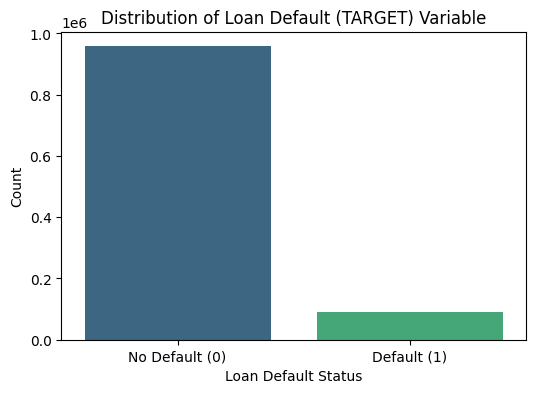

In [51]:
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, palette='viridis')
plt.xticks([0, 1], ['No Default (0)', 'Default (1)'])
plt.xlabel("Loan Default Status")
plt.ylabel("Count")
plt.title("Distribution of Loan Default (TARGET) Variable")
plt.show()

#### 4.7) PRINT THE PERCENTAGE OF EACH CLASS

In [52]:
default_ratio = target_counts / len(data) * 100
print(f"Class Distribution:\n{target_counts}\n")
print(f"Percentage Distribution:\n{default_ratio.round(2)}%")

Class Distribution:
TARGET
0    957563
1     91012
Name: count, dtype: int64

Percentage Distribution:
TARGET
0    91.32
1     8.68
Name: count, dtype: float64%


#### 4.8) DISPLAYING THE SHAPE OF THE TRAIN AND TEST SETS

In [53]:
print(f"Training Set: {X_train.shape}, Testing Set: {X_test.shape}")
print(f"Training Target: {y_train.shape}, Testing Target: {y_test.shape}")

Training Set: (838860, 103), Testing Set: (209715, 103)
Training Target: (838860,), Testing Target: (209715,)


### 4.9) FILL MISSING VALUES

In [54]:
num_cols = X_train.select_dtypes(include=['number']).columns
cat_cols = X_train.select_dtypes(exclude=['number']).columns

print("Numerical Columns:", num_cols)
print("Categorical Columns:", cat_cols)

Numerical Columns: Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x',
       'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START_x',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FL

In [55]:
X_train[num_cols] = X_train[num_cols].fillna(X_train[num_cols].median())
X_test[num_cols] = X_test[num_cols].fillna(X_test[num_cols].median())

In [56]:
X_train[cat_cols] = X_train[cat_cols].fillna(X_train[cat_cols].mode().iloc[0])
X_test[cat_cols] = X_test[cat_cols].fillna(X_test[cat_cols].mode().iloc[0])

In [57]:
print("Missing values in X_train:", X_train.isnull().sum().sum())
print("Missing values in X_test:", X_test.isnull().sum().sum())

Missing values in X_train: 0
Missing values in X_test: 0


### 5) CORRELATION ANALYSIS

#### 5.1) SELECT ONLY NUMERICAL COLUMNS

In [58]:
numeric_data = data.select_dtypes(include=['number'])

In [59]:
numeric_data.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,NaN,-606,500,24.0,365243.0,-565.0,125.0,-25.0,-17.0,0.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,NaN,-746,-1,12.0,365243.0,-716.0,-386.0,-536.0,-527.0,1.0
2,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,NaN,-828,1400,6.0,365243.0,-797.0,-647.0,-647.0,-639.0,0.0
3,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,NaN,-2341,200,12.0,365243.0,-2310.0,-1980.0,-1980.0,-1976.0,1.0
4,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,NaN,-815,30,4.0,365243.0,-784.0,-694.0,-724.0,-714.0,0.0


In [60]:
corr_matrix = numeric_data.corr()

In [61]:
corr_matrix.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
SK_ID_CURR,1.000000,-0.000055,-0.001088,-0.002515,-0.002729,-0.002834,-0.002448,-0.002896,-0.001822,0.002187,...,-0.028799,-0.001455,0.000624,0.000332,-0.001745,-0.002264,-0.000142,-0.000836,-0.000282,0.000882
TARGET,-0.000055,1.000000,0.019219,0.000012,-0.022310,-0.006562,-0.031011,-0.033528,0.074536,-0.045627,...,0.021000,0.039746,-0.002955,0.030990,-0.031427,-0.006739,0.018088,0.017014,0.016377,-0.000619
CNT_CHILDREN,-0.001088,0.019219,1.000000,0.011311,0.002712,0.030261,-0.001051,-0.022392,0.363465,-0.248801,...,-0.012565,-0.012516,0.001769,-0.055573,-0.002348,0.004062,0.000606,-0.011578,-0.010095,-0.054877
AMT_INCOME_TOTAL,-0.002515,0.000012,0.011311,1.000000,0.147770,0.182735,0.148766,0.067789,0.022624,-0.060217,...,0.014819,0.003405,0.001744,0.019596,-0.007693,-0.000861,0.006442,0.001206,0.001369,0.001682
AMT_CREDIT_x,-0.002729,-0.022310,0.002712,0.147770,1.000000,0.758429,0.986249,0.083466,-0.049482,-0.059190,...,-0.087114,-0.060611,0.005059,0.038487,-0.007145,0.002225,0.010400,-0.061337,-0.053439,-0.016076


#### 5.2) CORRELATION MATRIX

In [62]:
key_features = [
    "TARGET", "AMT_INCOME_TOTAL", "AMT_CREDIT_x", "AMT_ANNUITY_x",
    "AMT_GOODS_PRICE_x", "DAYS_BIRTH", "DAYS_EMPLOYED",
    "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"
]

In [63]:
selected_data = data[key_features]

In [64]:
corr_matrix = selected_data.corr()

In [65]:
corr_matrix.head()

,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,DAYS_BIRTH,DAYS_EMPLOYED,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
TARGET,1.000000,0.000012,-0.022310,-0.006562,-0.031011,0.074536,-0.045627,-0.152843,-0.156756,-0.186616
AMT_INCOME_TOTAL,0.000012,1.000000,0.147770,0.182735,0.148766,0.022624,-0.060217,0.023632,0.056860,-0.034887
AMT_CREDIT_x,-0.022310,0.147770,1.000000,0.758429,0.986249,-0.049482,-0.059190,0.161357,0.115388,0.040543
AMT_ANNUITY_x,-0.006562,0.182735,0.758429,1.000000,0.762340,0.028745,-0.108915,0.104002,0.109633,0.015693
AMT_GOODS_PRICE_x,-0.031011,0.148766,0.986249,0.762340,1.000000,-0.047934,-0.056151,0.167410,0.122870,0.044578


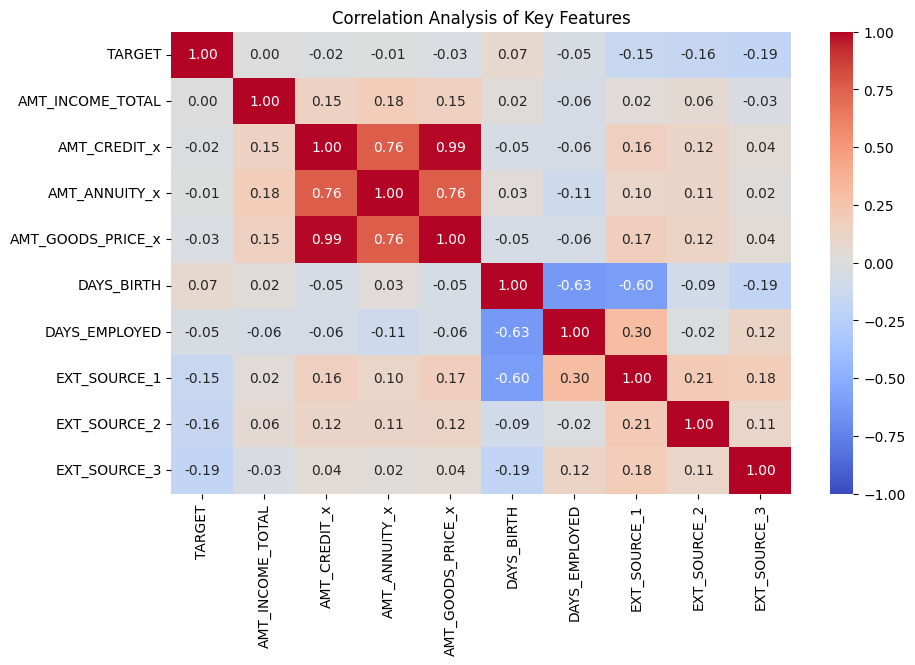

In [66]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Analysis of Key Features")
plt.show()

In [67]:
print("Correlation with TARGET:")
print(corr_matrix["TARGET"].sort_values(ascending=False))

Correlation with TARGET:
TARGET               1.000000
DAYS_BIRTH           0.074536
AMT_INCOME_TOTAL     0.000012
AMT_ANNUITY_x       -0.006562
AMT_CREDIT_x        -0.022310
AMT_GOODS_PRICE_x   -0.031011
DAYS_EMPLOYED       -0.045627
EXT_SOURCE_1        -0.152843
EXT_SOURCE_2        -0.156756
EXT_SOURCE_3        -0.186616
Name: TARGET, dtype: float64


### 6) FEATURE ENGINEERING

#### 6.1) HANDLING SKEWED DATA

In [68]:
skewed_features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x']
for feature in skewed_features:
    data[feature] = np.log1p(data[feature])

#### 6.2) REMOVING HIGHLY CORRELATED FEATURES

In [69]:
numeric_data = data.select_dtypes(include=['number'])

In [70]:
corr_matrix = numeric_data.corr()

In [71]:
high_corr_features = set()
threshold = 0.9

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            col_name = corr_matrix.columns[i]
            high_corr_features.add(col_name)

In [72]:
data.drop(columns=high_corr_features, inplace=True)

In [73]:
print(f"Removed {len(high_corr_features)} highly correlated features.")
print(f"New dataset shape: {data.shape}")

Removed 38 highly correlated features.
New dataset shape: (1048575, 120)


#### 6.3) ENCODING CATEGORICAL VARIABLE

#### 6.3.1) IDENTIFY CATEGORICAL COLUMNS

In [74]:
categorical_cols = data.select_dtypes(include=['object']).columns

In [75]:
categorical_cols

Index(['NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE_x', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START_x', 'ORGANIZATION_TYPE',
       'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE',
       'EMERGENCYSTATE_MODE', 'NAME_CONTRACT_TYPE_y',
       'WEEKDAY_APPR_PROCESS_START_y', 'FLAG_LAST_APPL_PER_CONTRACT',
       'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE_y', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP',
       'PRODUCT_COMBINATION'],
      dtype='object')

#### 6.3.2) APPLY ONE-HOT ENCODING TO CATEGORICAL VARIABLES

In [76]:
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [77]:
data_encoded.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest
0,100002,1,0,12.218500,12.915581,10.114619,0.018801,-9461,-637,-3648,...,False,False,False,False,False,False,False,False,True,False
1,100003,0,0,12.506181,14.072865,10.482892,0.003541,-16765,-1188,-1186,...,True,False,False,False,False,False,False,False,False,False
2,100003,0,0,12.506181,14.072865,10.482892,0.003541,-16765,-1188,-1186,...,False,False,False,False,True,False,False,False,False,False
3,100003,0,0,12.506181,14.072865,10.482892,0.003541,-16765,-1188,-1186,...,False,False,True,False,False,False,False,False,False,False
4,100004,0,0,11.119898,11.813037,8.817446,0.010032,-19046,-225,-4260,...,False,False,False,False,False,False,False,True,False,False


In [78]:
data_encoded.info(), data_encoded.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Columns: 336 entries, SK_ID_CURR to PRODUCT_COMBINATION_POS others without interest
dtypes: bool(248), float64(41), int64(47)
memory usage: 952.0 MB


(None,
    SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT_x  \
 0      100002       1             0         12.218500     12.915581   
 1      100003       0             0         12.506181     14.072865   
 2      100003       0             0         12.506181     14.072865   
 3      100003       0             0         12.506181     14.072865   
 4      100004       0             0         11.119898     11.813037   
 
    AMT_ANNUITY_x  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
 0      10.114619                    0.018801       -9461           -637   
 1      10.482892                    0.003541      -16765          -1188   
 2      10.482892                    0.003541      -16765          -1188   
 3      10.482892                    0.003541      -16765          -1188   
 4       8.817446                    0.010032      -19046           -225   
 
    DAYS_REGISTRATION  ...  PRODUCT_COMBINATION_Cash X-Sell: low  \
 0              -3648  ...       

In [79]:
print("Available columns in X_train:\n", X_train.columns.tolist())
print("\nMissing categorical columns:\n", [col for col in categorical_cols if col not in X_train.columns])

Available columns in X_train:
 ['SK_ID_CURR', 'NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'NAME_TYPE_SUITE_x', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START_x', 'HOUR_APPR_PROCESS_START_x', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIR

In [80]:
valid_categorical_cols = [col for col in categorical_cols if col in X_train.columns]

X_train = pd.get_dummies(X_train, columns=valid_categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=valid_categorical_cols, drop_first=True)


In [81]:
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [82]:
print(X_train.head())

        SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT_x  \
114669      129161             0          135000.0      417024.0   
685283      273561             0           76500.0      207306.0   
757756      291864             0          180000.0      135000.0   
657474      266451             0          247500.0      971280.0   
992436      350594             0          202500.0      550980.0   

        AMT_ANNUITY_x  AMT_GOODS_PRICE_x  REGION_POPULATION_RELATIVE  \
114669        28341.0           360000.0                    0.035792   
685283        14152.5           148500.0                    0.002134   
757756         6750.0           135000.0                    0.003813   
657474        54364.5           900000.0                    0.003813   
992436        36949.5           450000.0                    0.008019   

        DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  ...  \
114669      -10058           -931               -360  ...   
685283      -10846           -862   

In [83]:
print(X_test.head())

        SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT_x  \
996977      351711             1          337500.0      291114.0   
905454      328944             1          157500.0      412942.5   
270207      168428             0          180000.0      130824.0   
235061      159362             0           90000.0      327024.0   
518833      231318             0          139500.0      225000.0   

        AMT_ANNUITY_x  AMT_GOODS_PRICE_x  REGION_POPULATION_RELATIVE  \
996977        21897.0           243000.0                    0.025164   
905454        30055.5           373500.0                    0.006207   
270207         8869.5           103500.0                    0.018634   
235061        16033.5           270000.0                    0.007020   
518833         7065.0           225000.0                    0.010147   

        DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  ...  \
996977      -16807          -4962              -5932  ...   
905454       -9980           -710   

### 7) HANDLE CLASS IMBALANCE USING SMOTE

#### 7.1) USE SMOTE ON A SUBSET

In [84]:
sample_size = 100000 
X_sampled = X_train.sample(n=sample_size, random_state=42)
y_sampled = y_train.loc[X_sampled.index]

In [85]:
X_sampled.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest
130176,132961,0,225000.0,675000.0,34596.0,675000.0,0.010643,-17742,-2315,-11,...,False,False,False,False,False,False,False,False,False,False
399175,200947,0,112500.0,659610.0,21406.5,472500.0,0.024610,-20944,365243,-2438,...,False,False,False,False,False,False,True,False,False,False
511833,229561,0,157500.0,441657.0,13518.0,310500.0,0.003813,-15569,-2898,-1962,...,False,False,False,False,False,False,False,False,False,False
314227,179452,0,71100.0,571446.0,18562.5,477000.0,0.031329,-22207,365243,-14010,...,False,False,False,False,False,False,False,False,False,False
39344,109930,0,135000.0,719946.0,34767.0,643500.0,0.003813,-11480,-2022,-4876,...,False,False,False,False,False,False,True,False,False,False


In [86]:
y_sampled.head()

130176    0
399175    0
511833    0
314227    0
39344     0
Name: TARGET, dtype: int64

In [87]:
smote = SMOTE(random_state=42)

In [88]:
smote

SMOTE(random_state=42)

In [89]:
X_train_resampled, y_train_resampled = smote.fit_resample(X_sampled, y_sampled)

In [90]:
X_train_resampled.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest
0,132961,0,225000.0,675000.0,34596.0,675000.0,0.010643,-17742,-2315,-11,...,False,False,False,False,False,False,False,False,False,False
1,200947,0,112500.0,659610.0,21406.5,472500.0,0.024610,-20944,365243,-2438,...,False,False,False,False,False,False,True,False,False,False
2,229561,0,157500.0,441657.0,13518.0,310500.0,0.003813,-15569,-2898,-1962,...,False,False,False,False,False,False,False,False,False,False
3,179452,0,71100.0,571446.0,18562.5,477000.0,0.031329,-22207,365243,-14010,...,False,False,False,False,False,False,False,False,False,False
4,109930,0,135000.0,719946.0,34767.0,643500.0,0.003813,-11480,-2022,-4876,...,False,False,False,False,False,False,True,False,False,False


In [91]:
y_train_resampled

0         0
1         0
2         0
3         0
4         0
         ..
182855    1
182856    1
182857    1
182858    1
182859    1
Name: TARGET, Length: 182860, dtype: int64

#### 7.2) CHECK CLASS DISTRIBUTION AFTER SMOTE

In [92]:
print("Class distribution after SMOTE:", np.bincount(y_train_resampled))

Class distribution after SMOTE: [91430 91430]


#### 7.3) FEATURE SCALING (STANDARDIZATION)

In [93]:
scaler = StandardScaler()

In [94]:
scaler

StandardScaler()

In [95]:
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)

In [96]:
X_train_resampled_scaled

array([[-1.34065318, -0.50977121,  0.52808194, ..., -0.14185343,
        -0.14350946, -0.04226072],
       [-0.42159818, -0.50977121, -0.54965971, ..., -0.14185343,
        -0.14350946, -0.04226072],
       [-0.0347856 , -0.50977121, -0.11856305, ..., -0.14185343,
        -0.14350946, -0.04226072],
       ...,
       [ 0.65485037, -0.50977121, -0.21872716, ..., -0.14185343,
        -0.14350946, -0.04226072],
       [-0.80905964, -0.50977121, -0.73903457, ..., -0.14185343,
        -0.14350946, -0.04226072],
       [ 0.27487805, -0.50977121, -0.57385071, ..., -0.14185343,
        -0.14350946, -0.04226072]])

In [97]:
X_test_scaled = scaler.transform(X_test)

In [98]:
X_test_scaled

array([[ 1.61647449,  1.07164813,  1.60582358, ..., -0.14185343,
        -0.14350946, -0.04226072],
       [ 1.3087034 ,  1.07164813, -0.11856305, ..., -0.14185343,
        -0.14350946, -0.04226072],
       [-0.86119971, -0.50977121,  0.09698528, ..., -0.14185343,
        -0.14350946, -0.04226072],
       ...,
       [-1.64247622,  1.07164813,  0.09698528, ..., -0.14185343,
        -0.14350946, -0.04226072],
       [ 1.36445286, -0.50977121, -0.54965971, ..., -0.14185343,
        -0.14350946, -0.04226072],
       [-1.4388501 , -0.50977121, -0.54965971, ..., -0.14185343,
        -0.14350946, -0.04226072]])

### 8) MODEL SELECTION - TRAINING AND EVALUATION

### 8.1) LOGISTIC REGRESSION MODEL

#### 8.1.0) HYPERPARAMETER TUNING

In [99]:
param_grid = [
    {'solver': 'lbfgs', 'penalty': 'l2', 'C': 10},
    {'solver': 'saga', 'penalty': 'l2', 'C': 1}
]

In [100]:
best_auc = 0
best_params = None
best_model = None

for params in param_grid:
    print(f"🔹 Testing: {params}")
    
    log_reg = LogisticRegression(**params, max_iter=500, random_state=42)

🔹 Testing: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 10}
🔹 Testing: {'solver': 'saga', 'penalty': 'l2', 'C': 1}


In [101]:
log_reg

LogisticRegression(C=1, max_iter=500, random_state=42, solver='saga')

#### 8.1.1) TRAIN THE MODEL

In [102]:
log_reg.fit(X_train_resampled_scaled, y_train_resampled)

LogisticRegression(C=1, max_iter=500, random_state=42, solver='saga')

#### 8.1.2) MAKE PREDICTIONS

#### 8.1.2.1) PREDICTIONS ON TRAINING & TEST DATA

In [103]:
y_train_pred = log_reg.predict(X_train_resampled_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

In [104]:
y_train_pred

array([0, 0, 0, ..., 1, 1, 1])

In [105]:
y_test_pred

array([0, 0, 0, ..., 0, 0, 0])

#### 8.1.2.2) PROBABILITIES FOR ROC-AUC

In [106]:
y_train_proba = log_reg.predict_proba(X_train_resampled_scaled)[:, 1]
y_test_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

In [107]:
y_train_proba

array([0.22236954, 0.12562073, 0.07551616, ..., 0.99999872, 0.96999915,
       0.99958145])

In [108]:
y_test_proba

array([0.0264406 , 0.05839863, 0.07843911, ..., 0.06529758, 0.24473597,
       0.16647908])

#### 8.1.3) EVALAUTE THE MODEL

#### 8.1.3.1) ACCURACY

In [109]:
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

In [110]:
train_accuracy

0.9480804987422071

In [111]:
test_accuracy

0.9118708723744129

#### 8.1.4) CLASSIFICATION REPORT

In [112]:
print("🔹 Classification Report (Test Data):\n", classification_report(y_test, y_test_pred))

🔹 Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.92      1.00      0.95    191513
           1       0.40      0.03      0.06     18202

    accuracy                           0.91    209715
   macro avg       0.66      0.51      0.51    209715
weighted avg       0.87      0.91      0.88    209715



#### 8.1.5) ROC-AUC SCORE

In [113]:
train_roc_auc = roc_auc_score(y_train_resampled, y_train_proba)
test_roc_auc = roc_auc_score(y_test, y_test_proba)
print(f"🔹 Final ROC-AUC Score (Test): {test_roc_auc:.4f}")

🔹 Final ROC-AUC Score (Test): 0.7012


In [114]:
train_roc_auc

np.float64(0.971784426619045)

In [115]:
test_roc_auc

np.float64(0.7011849099357289)

In [116]:
print(f"🔹 Training Accuracy: {train_accuracy:.4f}")
print(f"🔹 Test Accuracy: {test_accuracy:.4f}")
print(f"🔹 ROC-AUC Score (Train): {train_roc_auc:.4f}")
print(f"🔹 ROC-AUC Score (Test): {test_roc_auc:.4f}")

🔹 Training Accuracy: 0.9481
🔹 Test Accuracy: 0.9119
🔹 ROC-AUC Score (Train): 0.9718
🔹 ROC-AUC Score (Test): 0.7012


#### 8.1.6) COMPUTE ROC CURVE

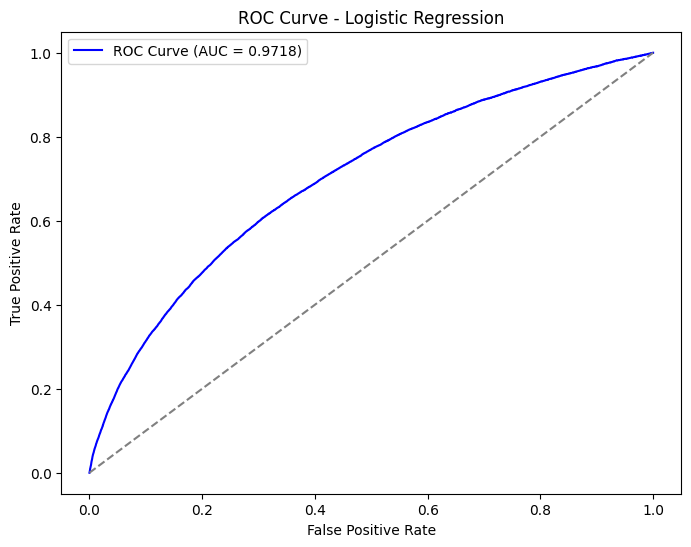

In [117]:
fpr, tpr, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {train_roc_auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


### 8.2) RANDOM FOREST CLASSIFIER

#### 8.2.0) HYPERPARAMETER TUNING

In [118]:
param_grid = [
    {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5},
    {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 10},
    {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 15},
]

In [119]:
best_auc = 0
best_params = None
best_model = None

for params in param_grid:
    print(f"🔹 Testing: {params}")
    
    rf_model = RandomForestClassifier(**params, random_state=42, n_jobs=-1)

🔹 Testing: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5}
🔹 Testing: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 10}
🔹 Testing: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 15}


In [120]:
rf_model

RandomForestClassifier(max_depth=20, min_samples_split=15, n_estimators=300,
                       n_jobs=-1, random_state=42)

#### 8.2.1) TRAIN THE MODEL

In [121]:
rf_model.fit(X_train_resampled_scaled, y_train_resampled)

RandomForestClassifier(max_depth=20, min_samples_split=15, n_estimators=300,
                       n_jobs=-1, random_state=42)

#### 8.2.2) MAKE PREDICTIONS

#### 8.2.2.1) PREDICTIONS ON TRAINING & TEST DATA

In [122]:
y_train_pred_rf = rf_model.predict(X_train_resampled_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

In [123]:
y_train_pred_rf

array([0, 0, 0, ..., 1, 1, 1])

In [124]:
y_test_pred_rf

array([0, 0, 0, ..., 0, 0, 0])

#### 8.2.2.2) PROBABILITIES FOR ROC-AUC

In [125]:
y_train_proba_rf = rf_model.predict_proba(X_train_resampled_scaled)[:, 1]
y_test_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

In [126]:
y_train_proba_rf

array([0.18604757, 0.18074786, 0.3423354 , ..., 0.96886163, 0.95242268,
       0.8839759 ])

In [127]:
y_test_proba_rf

array([0.09967879, 0.24076548, 0.43241694, ..., 0.19325659, 0.39289271,
       0.23162999])

#### 8.2.3) EVALAUTE THE MODEL

#### 8.2.3.1) ACCURACY

In [128]:
train_accuracy_rf = accuracy_score(y_train_resampled, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

In [129]:
train_accuracy_rf

0.9656513179481571

In [130]:
test_accuracy_rf

0.9091099825954271

#### 8.2.4) CLASSIFICATION REPORT

In [131]:
print("🔹 Classification Report (Test Data):\n", classification_report(y_test, y_test_pred_rf))

🔹 Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.92      0.99      0.95    191513
           1       0.41      0.10      0.17     18202

    accuracy                           0.91    209715
   macro avg       0.66      0.54      0.56    209715
weighted avg       0.88      0.91      0.88    209715



#### 8.2.5) ROC-AUC SCORE

In [132]:
train_roc_auc_rf = roc_auc_score(y_train_resampled, y_train_proba_rf)
test_roc_auc_rf = roc_auc_score(y_test, y_test_proba_rf)

In [133]:
train_roc_auc_rf

np.float64(0.9980989286740798)

In [134]:
test_roc_auc_rf

np.float64(0.735920197891562)

In [135]:
print(f"🔹 Training Accuracy: {train_accuracy_rf:.4f}")
print(f"🔹 Test Accuracy: {test_accuracy_rf:.4f}")
print(f"🔹 ROC-AUC Score (Train): {train_roc_auc_rf:.4f}")
print(f"🔹 ROC-AUC Score (Test): {test_roc_auc_rf:.4f}")

🔹 Training Accuracy: 0.9657
🔹 Test Accuracy: 0.9091
🔹 ROC-AUC Score (Train): 0.9981
🔹 ROC-AUC Score (Test): 0.7359


#### 8.2.6) COMPUTE ROC CURVE

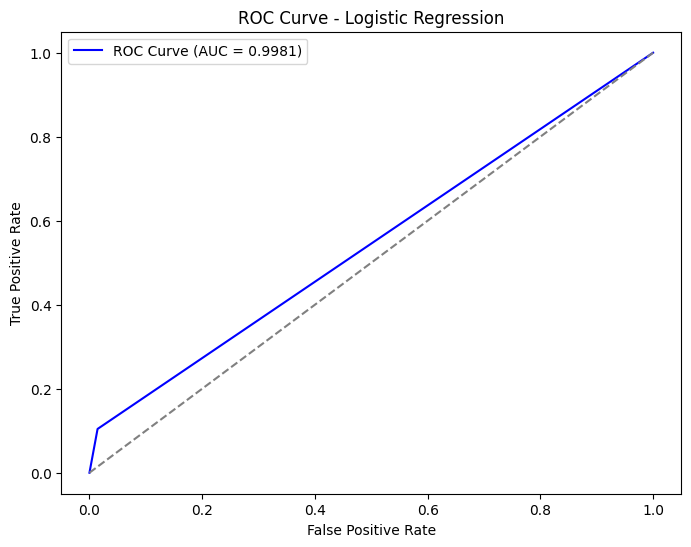

In [136]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {train_roc_auc_rf:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


### 8.3) XGBOOST CLASSIFER

In [137]:
param_grid = [
    {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8},
    {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.9},
    {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 1.0},
]

In [138]:
best_auc = 0
best_params = None
best_model = None

for params in param_grid:
    print(f"🔹 Testing: {params}")
    
    xgb = XGBClassifier(**params, random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)

🔹 Testing: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
🔹 Testing: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'subsample': 0.9}
🔹 Testing: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 1.0}


In [139]:
xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, ...)

#### 8.3.1) TRAIN THE MODEL

In [140]:
xgb.fit(X_train_resampled_scaled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, ...)

#### 8.3.2) MAKE PREDICTIONS

#### 8.3.2.1) PREDICTIONS ON TRAINING & TEST DATA

In [141]:
y_train_pred_xgb = xgb.predict(X_train_resampled_scaled)
y_test_pred_xgb= xgb.predict(X_test_scaled)

In [142]:
y_train_pred_xgb

array([0, 0, 0, ..., 1, 1, 1])

In [143]:
y_test_pred_xgb

array([0, 0, 0, ..., 0, 0, 0])

#### 8.3.2.2) PROBABILITIES FOR ROC-AUC

In [144]:
y_train_proba_xgb = xgb.predict_proba(X_train_resampled_scaled)[:, 1]
y_test_proba_xgb = xgb.predict_proba(X_test_scaled)[:, 1]

In [145]:
y_train_proba_xgb

array([0.23023131, 0.19359544, 0.35479552, ..., 0.9217647 , 0.9020375 ,
       0.88221383], dtype=float32)

In [146]:
y_test_proba_xgb

array([0.08809494, 0.11381295, 0.1908176 , ..., 0.19279152, 0.2694944 ,
       0.26932496], dtype=float32)

#### 8.3.3) EVALAUTE THE MODEL

#### 8.3.3.1) ACCURACY

In [147]:
train_accuracy_xgb = accuracy_score(y_train_resampled, y_train_pred_xgb)
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)

In [148]:
train_accuracy_xgb

0.9395876626927704

In [149]:
test_accuracy_xgb

0.9018572825024438

#### 8.3.4) CLASSIFICATION REPORT

In [150]:
print("🔹 Classification Report (Test Data):\n", classification_report(y_test, y_test_pred_xgb))

🔹 Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.92      0.98      0.95    191513
           1       0.25      0.07      0.11     18202

    accuracy                           0.90    209715
   macro avg       0.59      0.52      0.53    209715
weighted avg       0.86      0.90      0.88    209715



#### 8.3.5) ROC-AUC SCORE

In [151]:
train_roc_auc_xgb = roc_auc_score(y_train_resampled, y_train_proba_xgb)
test_roc_auc_xgb = roc_auc_score(y_test, y_test_proba_xgb)
print(f"🔹 Final ROC-AUC Score (Test): {test_roc_auc_xgb:.4f}")

🔹 Final ROC-AUC Score (Test): 0.6971


In [152]:
train_roc_auc_xgb

np.float64(0.9728762270446929)

In [153]:
test_roc_auc_xgb

np.float64(0.6971381151115502)

In [154]:
print(f"🔹 Training Accuracy: {train_accuracy_xgb:.4f}")
print(f"🔹 Test Accuracy: {test_accuracy_xgb:.4f}")
print(f"🔹 ROC-AUC Score (Train): {train_roc_auc_xgb:.4f}")
print(f"🔹 ROC-AUC Score (Test): {test_roc_auc_xgb:.4f}")

🔹 Training Accuracy: 0.9396
🔹 Test Accuracy: 0.9019
🔹 ROC-AUC Score (Train): 0.9729
🔹 ROC-AUC Score (Test): 0.6971


#### 8.3.6) COMPUTE ROC CURVE

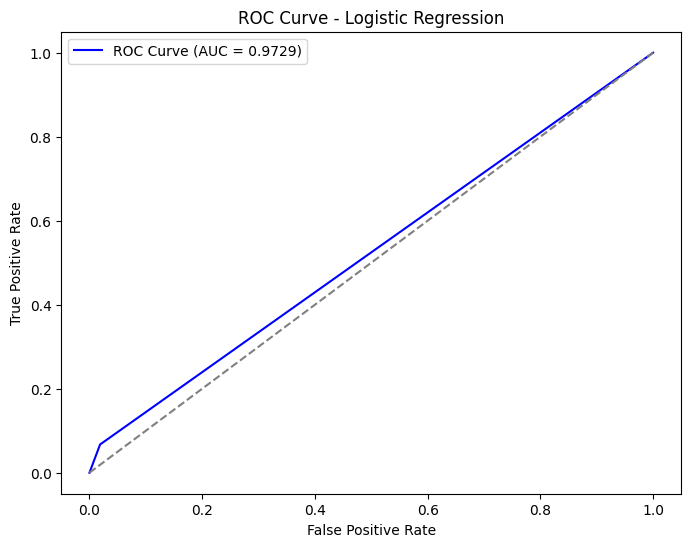

In [155]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {train_roc_auc_xgb:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


### 8.4) STOCHASTIC GRADIENT DESCENT

#### 8.4.0) HYPERPARAMETER TUNING

In [156]:
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],  
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.001, 0.01, 0.1, 1]  
}

In [157]:
sgd_search = RandomizedSearchCV(SGDClassifier(loss='hinge', random_state=42), 
                                param_grid, n_iter=10, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42)

In [158]:
sgd_search

RandomizedSearchCV(cv=3, estimator=SGDClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                                        'eta0': [0.001, 0.01, 0.1, 1],
                                        'learning_rate': ['constant', 'optimal',
                                                          'invscaling',
                                                          'adaptive']},
                   random_state=42, scoring='roc_auc')

#### 8.4.1) TRAIN THE MODEL

In [159]:
sgd_search.fit(X_train_resampled_scaled, y_train_resampled)

RandomizedSearchCV(cv=3, estimator=SGDClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
                                        'eta0': [0.001, 0.01, 0.1, 1],
                                        'learning_rate': ['constant', 'optimal',
                                                          'invscaling',
                                                          'adaptive']},
                   random_state=42, scoring='roc_auc')

In [160]:
best_sgd = sgd_search.best_estimator_

#### 8.4.2) MAKE PREDICTIONS

#### 8.4.2.1) PREDICTIONS ON TRAINING & TEST DATA

In [161]:
y_train_pred_sgd = best_sgd.predict(X_train_resampled_scaled)
y_test_pred_sgd = best_sgd.predict(X_test_scaled)

In [162]:
y_train_pred_sgd

array([0, 0, 0, ..., 1, 1, 1])

In [163]:
y_test_pred_sgd

array([0, 0, 0, ..., 0, 0, 0])

#### 8.4.3) EVALAUTE THE MODEL

#### 8.4.3.1) ACCURACY

In [164]:
train_accuracy_sgd = accuracy_score(y_train_resampled, y_train_pred_sgd)
test_accuracy_sgd = accuracy_score(y_test, y_test_pred_sgd)

In [165]:
train_accuracy_sgd

0.9354205403040577

In [166]:
test_accuracy_sgd

0.9121379014376654

#### 8.4.4) CLASSIFICATION REPORT

In [167]:
print("🔹 Classification Report (Test Data):\n", classification_report(y_test, y_test_pred_sgd))

🔹 Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.91      1.00      0.95    191513
           1       0.33      0.01      0.02     18202

    accuracy                           0.91    209715
   macro avg       0.62      0.51      0.49    209715
weighted avg       0.86      0.91      0.87    209715



#### 8.4.5) ROC-AUC SCORE

In [168]:
train_roc_auc_sgd = accuracy_score(y_test, y_test_pred_sgd)
test_roc_auc_sgd = roc_auc_score(y_test, best_sgd.decision_function(X_test_scaled))

In [169]:
train_roc_auc_sgd

0.9121379014376654

In [170]:
test_roc_auc_sgd

np.float64(0.6268696067176622)

In [171]:
print(f"🔹 Training Accuracy: {train_accuracy_sgd:.4f}")
print(f"🔹 Test Accuracy: {test_accuracy_sgd:.4f}")
print(f"🔹 ROC-AUC Score (Train): {train_roc_auc_sgd:.4f}")
print(f"🔹 ROC-AUC Score (Test): {test_roc_auc_sgd:.4f}")

🔹 Training Accuracy: 0.9354
🔹 Test Accuracy: 0.9121
🔹 ROC-AUC Score (Train): 0.9121
🔹 ROC-AUC Score (Test): 0.6269


#### 8.4.6) COMPUTE ROC CURVE

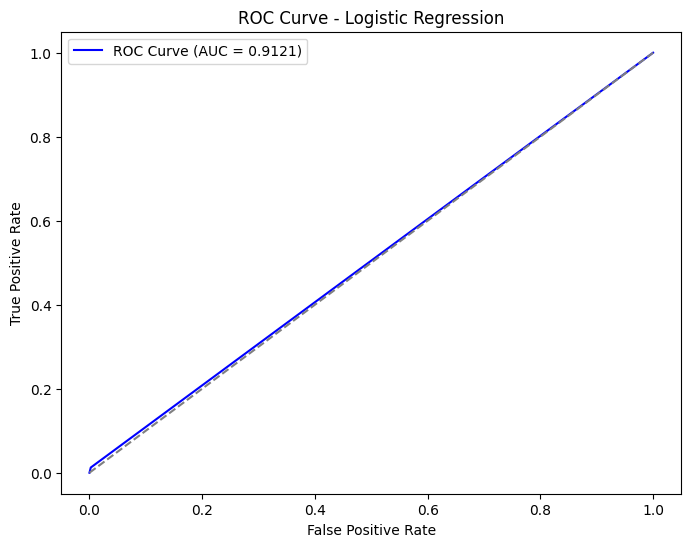

In [172]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred_sgd)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {train_roc_auc_sgd:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


### 9) DEEP LEARNING MODEL

#### 9.0) APPLY SMOTE TO TRAINING DATA

In [173]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_resampled_scaled, y_train_resampled)

X_train_final, X_val, y_train_final, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

#### 9.1) CALLBACK

In [174]:
class Class1RecallCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_val_pred = (self.model.predict(self.X_val, verbose=0) > 0.5).astype(int)
        recall = recall_score(self.y_val, y_val_pred)
        print(f"→ Epoch {epoch+1}: Class 1 Recall: {recall:.4f}")

#### 9.2) MODEL ARCHITECTURE 

In [175]:
model = Sequential([
    Dense(512, input_shape=(X_resampled.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(256, activation='relu'),
    Dropout(0.3),
    
    Dense(128, activation='relu'),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

#### 9.1) TRAIN THE MODEL

In [176]:
classes = np.unique(y_train_final)

# Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_final)

# Create dictionary
class_weights_dict = dict(zip(classes, weights))

print("Class Weights:", class_weights_dict)

Class Weights: {np.int64(0): np.float64(0.9997266415176863), np.int64(1): np.float64(1.0002735080137848)}


In [177]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=512,
    callbacks=[
        early_stop,
        Class1RecallCallback(X_val, y_val)
    ],
    class_weight=class_weights_dict,
    verbose=2
)


Epoch 1/10
→ Epoch 1: Class 1 Recall: 0.9003
286/286 - 23s - 81ms/step - accuracy: 0.9327 - auc: 0.9634 - loss: 0.1969 - val_accuracy: 0.9494 - val_auc: 0.9730 - val_loss: 0.1615
Epoch 2/10
→ Epoch 2: Class 1 Recall: 0.9012
286/286 - 15s - 54ms/step - accuracy: 0.9492 - auc: 0.9724 - loss: 0.1554 - val_accuracy: 0.9500 - val_auc: 0.9743 - val_loss: 0.1518
Epoch 3/10
→ Epoch 3: Class 1 Recall: 0.9009
286/286 - 16s - 56ms/step - accuracy: 0.9503 - auc: 0.9749 - loss: 0.1497 - val_accuracy: 0.9500 - val_auc: 0.9747 - val_loss: 0.1512
Epoch 4/10
→ Epoch 4: Class 1 Recall: 0.9029
286/286 - 15s - 53ms/step - accuracy: 0.9511 - auc: 0.9766 - loss: 0.1452 - val_accuracy: 0.9511 - val_auc: 0.9751 - val_loss: 0.1482
Epoch 5/10
→ Epoch 5: Class 1 Recall: 0.9049
286/286 - 15s - 53ms/step - accuracy: 0.9519 - auc: 0.9778 - loss: 0.1420 - val_accuracy: 0.9513 - val_auc: 0.9758 - val_loss: 0.1470
Epoch 6/10
→ Epoch 6: Class 1 Recall: 0.9063
286/286 - 15s - 52ms/step - accuracy: 0.9528 - auc: 0.9794 -

#### 9.1) EVALUATE THE MODEL

In [178]:
y_test_pred_proba = model.predict(X_test)
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# ROC AUC Score
print("ROC AUC Score:", roc_auc_score(y_test, y_test_pred_proba))

6554/6554 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.17      0.29    191513
           1       0.09      0.84      0.16     18202

    accuracy                           0.23    209715
   macro avg       0.50      0.50      0.22    209715
weighted avg       0.84      0.23      0.28    209715

Confusion Matrix:
[[ 32584 158929]
 [  2953  15249]]
ROC AUC Score: 0.504013469041469


### 10) GEN-AI RISK SCORE

In [179]:
def get_derived_risk_score(age, income, employment_status, credit_score):
    age_weight = max(0, min(1, (70 - age) / 70))  
    income_weight = max(0, min(1, income / 200000))  
    credit_weight = max(0, min(1, credit_score / 850))  

    emp_factor = {
        "Full-time": 0.1,
        "Part-time": 0.3,
        "Self-employed": 0.2,
        "Unemployed": 0.5,
        "Student": 0.4
    }
    employment_weight = 1 - emp_factor.get(employment_status, 0.3)

    risk_score = 1 - (0.3 * income_weight + 0.3 * credit_weight + 0.2 * age_weight + 0.2 * employment_weight)
    return round(risk_score, 2)
age = 45
income = 85000
employment_status = "Full-time"
credit_score = 710

score = get_derived_risk_score(age, income, employment_status, credit_score)
print(f"Derived Risk Score: {score}")


Derived Risk Score: 0.37
